In [10]:
import utils
from preprocessing import *
SIZE = 256

In [11]:
img_train, mask_train = prepareDataset(TRAIN_CONTOUR_PATH, TRAIN_IMG_PATH)
img_test, mask_test = prepareDataset(TEST_CONTOUR_PATH, TEST_IMG_PATH)
img_val, mask_val = prepareDataset(VAL_CONTOUR_PATH, VAL_IMG_PATH)

Number of examples: 260

Processing 260 images and labels ...

Number of examples: 279

Processing 279 images and labels ...

Number of examples: 266

Processing 266 images and labels ...



In [12]:
ROI_train = get_ROI(TRAIN_CONTOUR_PATH)

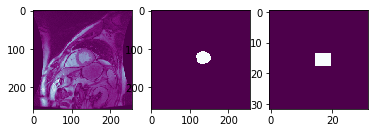

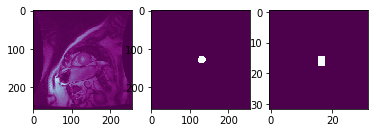

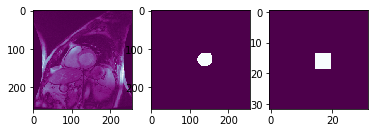

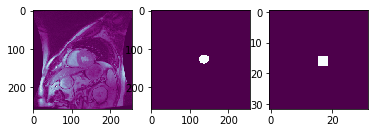

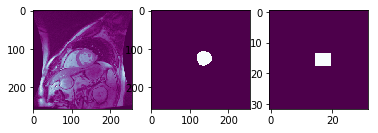

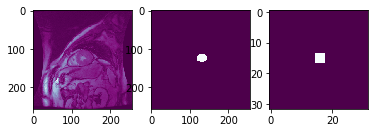

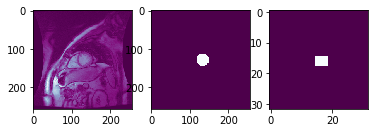

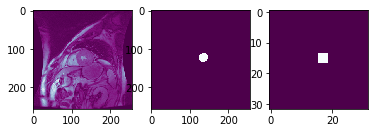

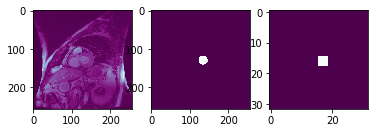

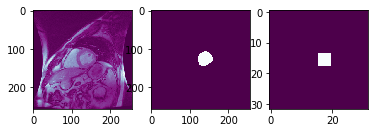

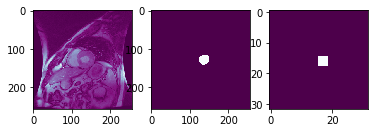

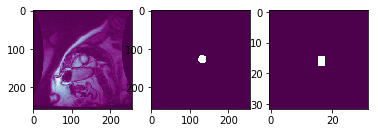

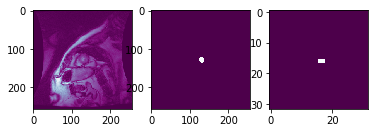

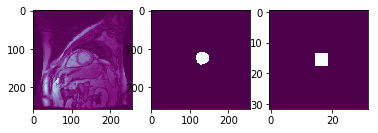

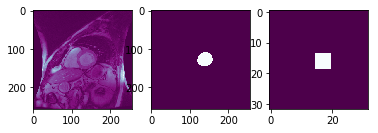

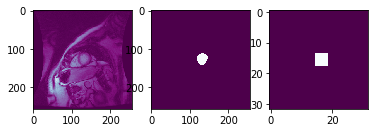

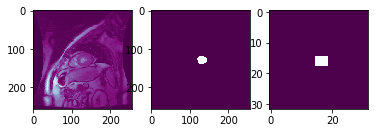

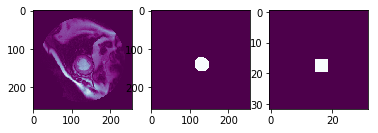

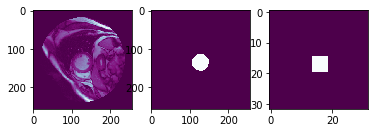

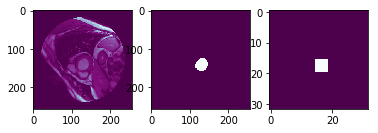

In [13]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
for i in range(20):
    mask = mask_train[i, :, :, 0]
    img = img_train[i, :, :, 0]
    plt.figure()
    plt.subplot(131)
    plt.imshow(img, cmap=plt.cm.BuPu_r)
    plt.subplot(132)
    plt.imshow(mask, cmap=plt.cm.BuPu_r)
    plt.subplot(133)
    plt.imshow(ROI_train[i],cmap=plt.cm.BuPu_r)

In [15]:
#reshape the data for CNN

print(img_train.shape)
print(len(ROI_train))
print(len(ROI_train[0]))
X = np.zeros((img_train.shape[0], 64, 64, 1))
for i in range(X.shape[0]):
    X[i,:,:,0] = cv2.resize(img_train[i,:,:,0], (64, 64), interpolation = cv2.INTER_LINEAR)
Y = np.array(ROI_train).reshape((len(ROI_train),1, 32, 32))

(260, 256, 256, 1)
260
32


(260, 64, 64, 1)
(260, 1, 32, 32)


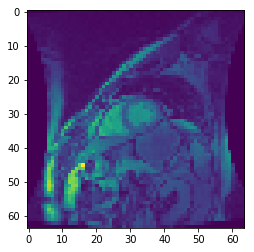

In [16]:
print(X.shape)
print(Y.shape)
plt.imshow(X[0,:,:,0])

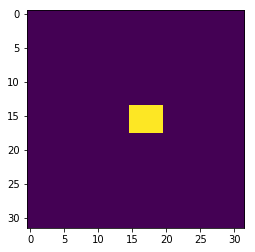

In [17]:
plt.imshow(Y[0,0,:,:])

In [18]:
from baseline_model import *
model = create_model()

Size for each layer :
Layer, Input Size, Output Size
('Conv2D_2', (None, 64, 64, 1), (None, 54, 54, 100))
('Average_Pooling2D_2', (None, 54, 54, 100), (None, 9, 9, 100))
('Reshape_3', (None, 9, 9, 100), (None, 1, 8100))
('Dense_2', (None, 1, 8100), (None, 1, 1024))
('Reshape_4', (None, 1, 1024), (None, 1, 32, 32))


In [19]:
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])
h = training(model, X, Y, batch_size=16, epochs= 20, data_augm=False)

Epoch 1/20
260/260 [==============================] - 4s 17ms/step - loss: 0.2332 - acc: 0.1578
Epoch 2/20
260/260 [==============================] - 3s 13ms/step - loss: 0.1426 - acc: 0.1894
Epoch 3/20
260/260 [==============================] - 3s 12ms/step - loss: 0.1105 - acc: 0.2284
Epoch 4/20
260/260 [==============================] - 4s 14ms/step - loss: 0.0920 - acc: 0.1474
Epoch 5/20
260/260 [==============================] - 3s 13ms/step - loss: 0.0783 - acc: 0.1031
Epoch 6/20
260/260 [==============================] - 3s 13ms/step - loss: 0.0683 - acc: 0.0675
Epoch 7/20
260/260 [==============================] - 3s 13ms/step - loss: 0.0607 - acc: 0.0500
Epoch 8/20
260/260 [==============================] - 3s 13ms/step - loss: 0.0548 - acc: 0.0425
Epoch 9/20
260/260 [==============================] - 4s 14ms/step - loss: 0.0496 - acc: 0.0435
Epoch 10/20
260/260 [==============================] - 3s 13ms/step - loss: 0.0445 - acc: 0.0410
Epoch 11/20
260/260 [==================

In [34]:
ROI_val = get_ROI(VAL_CONTOUR_PATH)
X_val = np.zeros((img_val.shape[0], 64, 64, 1))
for i in range(X_val.shape[0]):
    X_val[i,:,:,0] = cv2.resize(img_val[i,:,:,0], (64, 64), interpolation = cv2.INTER_LINEAR)
Y_val = np.array(ROI_val).reshape((len(ROI_val),1, 32, 32))

In [35]:
print(X_val.shape)
print(Y_val.shape)

(266, 64, 64, 1)
(266, 1, 32, 32)


In [36]:
y_pred = model.predict(X_val, batch_size = 16)

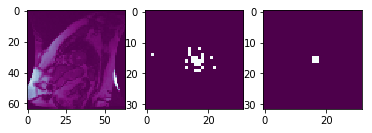

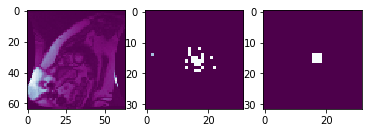

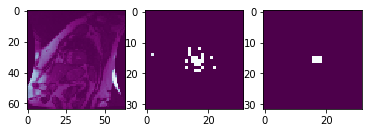

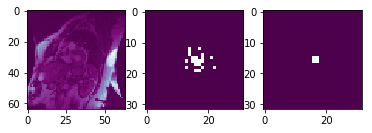

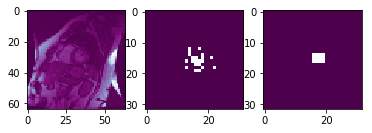

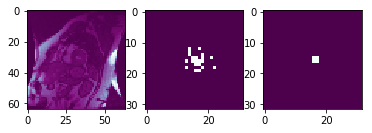

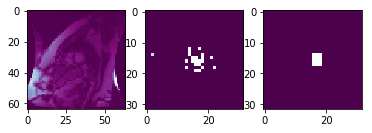

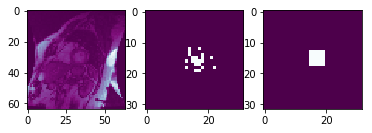

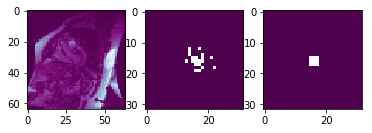

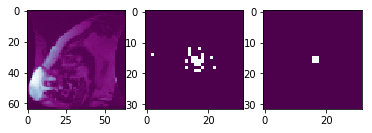

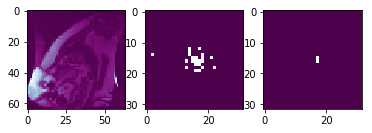

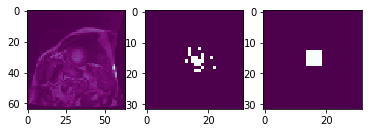

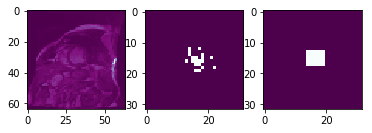

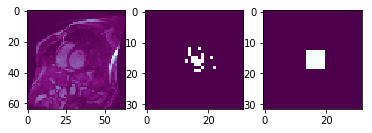

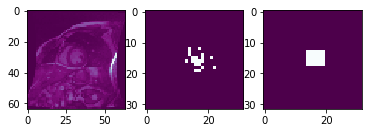

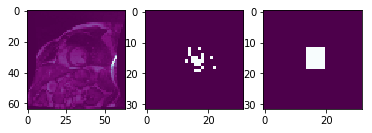

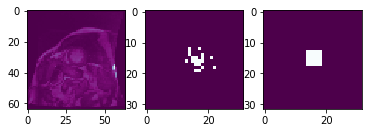

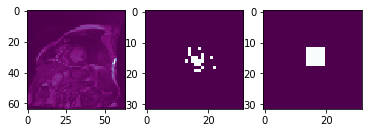

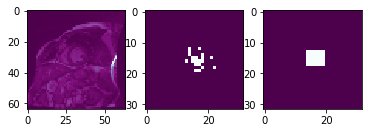

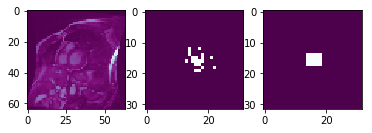

In [37]:
for i in range(20, 40, 1):
    mask = y_pred[i, 0, :, :]
    img = X_val[i, :, :, 0]
    plt.figure()
    plt.subplot(131)
    plt.imshow(img, cmap=plt.cm.BuPu_r)
    plt.subplot(132)
    plt.imshow(mask, cmap=plt.cm.BuPu_r)
    plt.subplot(133)
    plt.imshow(ROI_val[i],cmap=plt.cm.BuPu_r)

In [6]:
def compute_roi_pred(y_pred, idx, roi_shape=32):
    """
    Computing and cropping a ROI from the original image for further processing in the next stage
    :param y_pred: predictions
    :param idx: desired image prediction index
    :param roi_shape: shape of the binary mask
    """
    # up sampling from 32x32 to original MR size
    pred = cv2.resize(y_pred[idx].reshape((roi_shape, roi_shape)), (
                      256,256), cv2.INTER_NEAREST)
    # select the non null pixels
    pos_pred = np.array(np.where(pred > 0.5))
    # get the center of the mask
    X_min, Y_min = pos_pred[0, :].min(), pos_pred[1, :].min()
    X_max, Y_max = pos_pred[0, :].max(), pos_pred[1, :].max()  
    X_middle = X_min + (X_max - X_min) / 2
    Y_middle = Y_min + (Y_max - Y_min) / 2
    # Find ROI coordinates
    X_top = int(X_middle - 50)
    Y_top = int(Y_middle - 50)
    X_down = int(X_middle + 50)
    Y_down = int(Y_middle + 50)
    # crop ROI of size 100x100
    mask_roi = np.zeros((256, 256))
    mask_roi = cv2.rectangle(mask_roi, (X_top, Y_top), (X_down, Y_down), 1, -1)*255
    return X_fullsize[idx][X_top:X_down, Y_top:Y_down], mask_roi, contour_mask[idx][X_top:X_down, Y_top:Y_down]

In [7]:
pred2, mask_roi, mask_contour = compute_roi_pred(y_pred, 234)

NameError: name 'y_pred' is not defined